In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

import warnings as warns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV 
from datetime import datetime as dt
from sklearn import metrics 

import matplotlib.pyplot as plots 
import plotly.graph_objects as gr_objs
import seaborn as sns
import matplotlib.pyplot as plts
from sklearn.linear_model import LinearRegression as LinReg  #Linear Regression
from sklearn.ensemble import RandomForestRegressor as RnForReg  #Random Forest Regression
from sklearn.svm import SVR #Support Vector Machine Regression
from sklearn.linear_model import BayesianRidge as BayesR   #Bayesian Ridge Regression 
from copy import deepcopy




def manipulators(count,duplicated=True,repeated=True):
    """ Sets up permutation pairs """
    mnv=0
    mxv=count
    variations=[(i,j) for i in range(mnv,mxv) for j in range(mnv,mxv)]
    if not duplicated: 
        for k in range(mnv,mxv): variations.remove((k,k))
    if not repeated:
        for vars in variations: 
            if (vars[1],vars[0]) in variations: variations.remove(vars) 
    return variations
def yearVariation(data,year):
    """ Generate visual statistics of variation of a time-series data with year """
    data_local=data[data.index.year==year]
    cols=data.columns
    Fig=plts.figure(figsize=(15,7.5));ax=Fig.add_subplot(111);
    sns.lineplot(data=data_local)
    plts.xlabel('Year : %d'%year)
    plts.title(str(list(cols))[2:-2]+' for '+str(year))
    return plts.show()


In [2]:
class Forecaster():
    """ Class Forecaster 
    target operation: Forcast with machine learning models,
        the nature of data fluctuations in a stock price dataset. """

    # variables 
    model=None
    predicts=None
    infers=None
    data=None
    XData=None
    YData=None
    split_data=None
    metric=None

    def __init__(self, model, **kwargs):
        """ Class Forcaster 
         creates a forcasting model 
        
         prameters: 
        model : the class of forcasting model 
        other parameters are with regards to specific variables in those classes """

        self.model=model
        for var in kwargs:
            if hasattr(self.model,var):
                setattr(self.model,var,kwargs[var])

            # end of init
    
    def pushData(self,data,predicts,infers):
        """ Input the data that the model will use to train 
            parameters---
            data: pandas.DataFrame object 
            predicts: list of field names used as predictors 
            infers: list of field name """

        
        if type(data) != pd.DataFrame:
            raise TypeError(" data must be a pandas.DataFrame type object ")
        if type(predicts) != list:
            raise TypeError(" predicts must be a list datatype ")
        self.data=data
        self.predicts=predicts
        if type(infers) is list:
            self.infers=infers[0]
        elif type(infers) is str:
            self.infers=infers
        else:
            raise TypeError(" infers must be a list or string datatype ")
        self.XData=self.data[self.predicts]
        self.YData=self.data[self.infers]

        #end of pushData

    def normal_split(self):
        """ Trains the forecasting model """ 
        X_train,X_test,y_train,y_test=train_test_split(self.XData,self.YData,test_size=0.3,random_state=0)
        self.split_data={'Train':{'x':X_train,'y':y_train},'Test':{'x':X_test,'y':y_test}}
        

    def crossval_KF_split(self, **kwargs):
        """ Creates the training and testing sets on K fold cross validation """
        CrsV=KFold();
        for var in kwargs:
            if hasattr(CrsV,var):
                setattr(CrsV,var,kwargs[var])
        if [self.XData,self.YData] != [None,None]:
            for train_index, test_index in CrsV.split(self.XData):
                X_train,X_test=self.XData.iloc[train_index],self.XData.iloc[test_index]
                y_train,y_test=self.YData.iloc[train_index],self.YData.iloc[test_index]
            self.split_data={'Train':{'x':X_train,'y':y_train},'Test':{'x':X_test,'y':y_test}}
        else:
            raise ValueError(" No X,Y definition found ")
        
    def train(self):
        """ Trains the model on given data """
        self.model.fit(self.split_data['Train']['x'],self.split_data['Train']['y'])
    
    def train_full(self):
        """ Trains on the whole data """
        self.model.fit(self.XData,self.YData)

    def plotMetrics(self,data,title="Model: unspecified"):
        """ Plots variation of the trained data """
        XData=data[self.predicts]
        YData=data[self.infers]
        prediction=self.model.predict(XData)
        anotStr='\n'.join((r" Mean Absolute Error : %f".ljust(45,' ')%metrics.mean_absolute_error(YData,prediction),
        r" Mean Squared Error : %f".ljust(45,' ')%metrics.mean_squared_error(YData,prediction),
        r" Root Mean Squared Error : %f".ljust(45,' ')%np.sqrt(metrics.mean_squared_error(YData,prediction)),
        r" R{:} : %f".format('\xb2').ljust(45,' ')%metrics.r2_score(YData,prediction),
        r" Adjusted R{:} : %f".format('\xb2').ljust(45,' ')%(1-(1-metrics.r2_score(YData,prediction))*(len(YData)-1)/(len(YData)-XData.shape[1]-1)),
        r" Mean Absolute Percentage Error : %f".ljust(45,' ')%self.mean_absolute_percentage_error(YData,prediction)))
        Fig=plots.figure(figsize=(15,7.5));ax=Fig.add_subplot(111);
#         plots.plot(data.index,data[[self.infers]])
        plots.plot_date(data.index,prediction,'g.-')
        plots.text(0.147,0.915,anotStr,horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
        plots.title(title)
        plots.show()

    def getThetas(self):
        """ Return the set of coefficients or thetas governing the model """
        C0=self.model.intercept_
        CN=self.model.coef_
        params=np.concatenate((np.array([C0]),CN))
        return params

    def cost_function(self,Xjs,Yjs,thetas):
        """ Calculate the Cost incurred of Error residues """
        
        phi_thetas=Yjs
        psi_theta=np.dot(Xjs,thetas)
        deltas=psi_theta-phi_thetas
        m=len(self.YData)
        cost=np.sum(np.square(deltas))*0.5/m
        return cost

    def grad_decent(self,alpha=0.01,iters=100):
        """ Use Gradient Decent method to purify model """
        m=len(self.YData)
        Xjs=np.c_[np.ones((len(self.XData),1)),self.XData]
        phi_thetas=self.YData
        thetas=self.getThetas()
        History={'Costs':{},'Thetas':{}}
        for steps in range(iters):
            psi_theta=np.dot(Xjs,thetas)
            deltas=psi_theta-phi_thetas
            del_J_del_theta=Xjs.T.dot(deltas)/m
            thetas=thetas-alpha*del_J_del_theta
            History['Costs'][steps]=self.cost_function(Xjs=Xjs,Yjs=phi_thetas,thetas=thetas)
            History['Thetas'][steps]=thetas
        return History
        
    
    def gradientEnhanced(self,alpha=0.01,iters=100):
        """ Use Gradient descent functionality to provide an improved model"""
        History=self.grad_decent(alpha=alpha,iters=iters)
        minDeltaCost=min(History['Costs'].values())
        best_cost=0
        best_theta=0
        for i in range(iters):
            if History['Costs'][i]==minDeltaCost: 
                best_cost=History['Costs'][i]
                best_theta=History['Thetas'][i]
        self.model.intercept_=best_theta[0]
        self.model.coef_=best_theta[1:]
        self.metric={'ModelClass':type(self.model),'Best cost found':best_cost}
        return self.model

    def hyperboost(self,evaluator=GridSearchCV,param_grid={},**kwargs):
       
        worker=evaluator(estimator=self.model,param_grid=param_grid);
        for var in kwargs:
            if hasattr(worker,var):
                setattr(worker,var,kwargs[var])
        worker.fit(self.split_data['Train']['x'],self.split_data['Train']['y'])
        return worker.best_estimator_
        
    def accuracy(self):
        """ Calculate the Accuracy of the Regression Model """
        predict=self.model.predict(self.split_data['Test']['x'])
        errs=abs(predict-self.split_data['Test']['y'])
        MAE_P=100*np.mean(errs/self.split_data['Test']['y'])
        return 100- MAE_P

#    
    
    def mean_absolute_percentage_error(self,y_true,y_predic):
        """ Function emulates the function of the same name as is
        in sklearn.metrics of sklearn.__version__==0.24
        this is done for conda/anaconda related environment where sklearn.__version__==0.23.x 
        """
        errs=abs(y_predic-y_true)
        MAE_P=100*np.mean(errs/y_true)
        return MAE_P
    
    def residualTest(self,title,lineformat='C0:'):
        """ Plot Residual plot on Test Data"""
        Fig=plots.figure(figsize=(9,5.5));
        ax1=Fig.add_subplot(111);
        X=self.split_data["Test"]['x']
        X_lines=X.index
        YTrue=self.split_data["Test"]['y']
        YPred=self.model.predict(X)
        residualsPlot(X_lines,YTrue,YPred,title=title,linefmt=lineformat)
        plots.show()

# 

In [3]:
    dataHist=pd.read_csv("BrentOilPrices.csv")
    if 'Price' in dataHist.columns :
        dataHist.rename(columns={'Price':'Close'},inplace=True)


In [4]:
def data_Live(ticker="BZ=F",period="2M"):
    """ Access or import live/current of a given stock """
    dataRaw=yf.Ticker(ticker)
    DFrame=dataRaw.history(period=period)
    return DFrame

In [5]:
def data_FixedTimeLine(ticker="BZ=F",start=None,end=None):
    """ Access or import stock data of a fixed timeline """
    if start is None or end is None:
        warns.warn(" Start or End limit must have some values, it shouldn't be (None) ",category=SyntaxWarning)
        if start is None and end != None:
            dataRaw=yf.download(ticker,start=dt.now().date(),end=end)
        if start != None and end is None:
            dataRaw=yf.download(ticker,start=start,end=dt.now().date())
        if start is None and end is None:    
            dataRaw=yf.Ticker(ticker).history()
    else:
        dataRaw=yf.download(ticker,start=start,end=end)
    return dataRaw

In [6]:
def standardize(data,class_=StandardScaler):
    """ Standardize the Data given """
    cols=data.columns
    indexes=data.index
    scaler=class_()
    scaled=scaler.fit_transform(data)
    return pd.DataFrame(data=scaled,columns=cols,index=indexes)


In [7]:
def normalization(data,func_=normalize):
    """ Normalize the given data """
    cols=data.columns
    indexes=data.index
    normed=func_(data)
    return pd.DataFrame(data=normed,columns=cols,index=indexes)

In [8]:
dHs=data_FixedTimeLine("BZ=F",start="2015-10-01",end="2022-12-30")  #for model creation
dhR=data_Live(period='5mo')  

[*********************100%***********************]  1 of 1 completed


In [9]:
def stockCandle(data,title=''):
    """ Create a Candlestick chart for stock market like data 
    *********************
    Variables
    ---------------------
    data : pandas.DataFrame object with specified definition type 
    title: title to the chart 

    Dataframe definition type must follow
    1. Date must be indexed 
    2. Date index must be a datetime object
    3. Must have 'Open','High','Low','Close' columns of data 
    _________________________
    returns a plotted candlestick chart with sliders 
    """
    Fig = gr_objs.Figure(data=[gr_objs.Candlestick(x=data.index,
                open=data.Open, high=data.High,
                low=data.Low, close=data.Close)],
                layout=gr_objs.Layout(title=gr_objs.layout.Title(text=title)))
    return Fig.show()

In [10]:
stockCandle(dHs,title=" Brent Oil Price Fluctuations from October,2015 to December,2022 (BZ=F) ")

In [11]:
dHs.head(10)

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2015-10-01  48.380001  49.840000  47.639999  47.689999  47.689999   23765
2015-10-02  48.060001  48.490002  46.939999  48.130001  48.130001   21721
2015-10-05  48.250000  49.860001  47.889999  49.250000  49.250000   19936
2015-10-06  49.270000  52.259998  48.860001  51.919998  51.919998   27925
2015-10-07  51.490002  53.139999  51.220001  51.330002  51.330002   28754
2015-10-08  51.810001  53.560001  51.290001  53.049999  53.049999   28101
2015-10-09  53.270000  54.049999  52.230000  52.650002  52.650002   32991
2015-10-12  52.610001  53.299999  49.779999  49.860001  49.860001   30617
2015-10-13  50.299999  50.689999  48.900002  49.240002  49.240002   18780
2015-10-14  49.169998  49.500000  48.730000  49.150002  49.150002    8412

In [12]:
dHs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1820 entries, 2015-10-01 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1820 non-null   float64
 1   High       1820 non-null   float64
 2   Low        1820 non-null   float64
 3   Close      1820 non-null   float64
 4   Adj Close  1820 non-null   float64
 5   Volume     1820 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 99.5 KB


In [13]:
dHs.describe()

Open         High          Low        Close    Adj Close  \
count  1820.000000  1820.000000  1820.000000  1820.000000  1820.000000   
mean     63.446604    64.455451    62.433302    63.473242    63.473242   
std      19.479768    19.858273    19.112910    19.514133    19.514133   
min      19.559999    21.270000    16.000000    19.330000    19.330000   
25%      49.164999    49.840000    48.447499    49.114999    49.114999   
50%      62.000000    62.820002    61.180000    62.065001    62.065001   
75%      73.897497    74.822500    72.917503    73.922499    73.922499   
max     129.570007   137.000000   122.500000   127.980003   127.980003   

             Volume  
count   1820.000000  
mean   29489.284615  
std    12927.533066  
min        0.000000  
25%    22209.500000  
50%    29211.000000  
75%    36430.750000  
max    87185.000000

In [14]:
dhR.head(10)

Open       High        Low      Close  Volume  \
Date                                                                            
2022-12-05 00:00:00-05:00  85.519997  88.430000  82.540001  82.680000   25039   
2022-12-06 00:00:00-05:00  83.089996  83.669998  78.709999  79.349998   26680   
2022-12-07 00:00:00-05:00  79.790001  80.480003  76.940002  77.169998   26919   
2022-12-08 00:00:00-05:00  77.489998  79.180000  75.760002  76.150002   33131   
2022-12-09 00:00:00-05:00  76.730003  77.470001  75.110001  76.099998   24479   
2022-12-12 00:00:00-05:00  76.669998  78.580002  75.260002  77.989998   23020   
2022-12-13 00:00:00-05:00  78.190002  81.279999  78.040001  80.680000   30052   
2022-12-14 00:00:00-05:00  80.339996  83.139999  80.129997  82.699997   27330   
2022-12-15 00:00:00-05:00  82.839996  83.190002  80.830002  81.209999   26470   
2022-12-16 00:00:00-05:00  81.339996  81.760002  78.279999  79.040001   24439   

                           Dividends  Stock Splits  
Date                                                
2022-12-05 00:00:00-05:00          0             0  
2022-12-06 00:00:00-05:00          0             0  
2022-12-07 00:00:00-05:00          0             0  
2022-12-08 00:00:00-05:00          0             0  
2022-12-09 00:00:00-05:00          0             0  
2022-12-12 00:00:00-05:00          0             0  
2022-12-13 00:00:00-05:00          0             0  
2022-12-14 00:00:00-05:00          0             0  
2022-12-15 00:00:00-05:00          0             0  
2022-12-16 00:00:00-05:00          0             0

In [15]:
dhR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2022-12-05 00:00:00-05:00 to 2023-05-05 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          106 non-null    float64
 1   High          106 non-null    float64
 2   Low           106 non-null    float64
 3   Close         106 non-null    float64
 4   Volume        106 non-null    int64  
 5   Dividends     106 non-null    int64  
 6   Stock Splits  106 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 6.6 KB


In [16]:
dhR.describe()

Open        High         Low       Close        Volume  \
count  106.000000  106.000000  106.000000  106.000000    106.000000   
mean    81.928207   83.112830   80.402830   81.722925  23359.943396   
std      3.819266    3.698005    4.047968    3.887011   8612.898947   
min     71.889999   73.250000   68.199997   72.330002      0.000000   
25%     79.357498   80.879997   78.042501   79.279997  18169.000000   
50%     82.789997   83.649998   81.209999   82.665001  24677.000000   
75%     84.927498   85.962500   83.747499   84.922501  28707.000000   
max     88.029999   89.099998   86.930000   88.190002  46598.000000   

       Dividends  Stock Splits  
count      106.0         106.0  
mean         0.0           0.0  
std          0.0           0.0  
min          0.0           0.0  
25%          0.0           0.0  
50%          0.0           0.0  
75%          0.0           0.0  
max          0.0           0.0

In [17]:
def fullDataPlots(data,method=sns.pairplot,title=None,window_dim=(15,10)):
    """ Plot functionalities for full dataset plots
     like pairplots and boxplots 
     ********************
    Variables 
    -----------------------
    data : pandas.DataFrame object
    method : sns plot function object  
    title : plot title
    ------------------------
    returns figure object  
    """
    #Fig=plts.figure(figsize=window_dim);#ax=Fig.add_subplot(111);
    figHandler=method(data=data);Fig=plts.gcf()
    Fig.set_figwidth(15)
    Fig.set_figheight(7.5)
    #Fig.resize(window_dim[0],window_dim[1])
    Fig.suptitle(title)
    plts.subplots_adjust(0.064,0.06,0.983,0.938)
    return plts.show()

In [18]:
def multiPlots(data,method=sns.scatterplot,unique_pairs=True):
    """ Plot multiple plots dpending on the requirements set
    ********************
    Variables 
    -------------------
    data :  pandas dataframe object 
    method : (deafult) sns.scatterplot -> plotting function  
    unique_pairs : (default) True -> plots of pairs, only those of which are unique

    ********************

    #need later revision in parameter usage and detailing for 'method' and 'grid' variable """

    # type error handling
    if type(data) != pd.DataFrame: raise ValueError("Data type must be a pandas.Dataframe object")

    #Body
    cols=data.columns
    permutes=manipulators(len(cols),duplicated=False,repeated=False) if unique_pairs else manipulators(len(cols))
    plotFunc= method
    for a_pair in permutes:
        x_index= cols[a_pair[0]]
        y_index= cols[a_pair[1]]
        titled= x_index + ' vs ' + y_index
#         singlePlot(plotFunc,data[x_index],data[y_index],xlabel=x_index,ylabel=y_index,title=titled,window_dim=(12,10))        
    print(' Plot Success ***** ')    


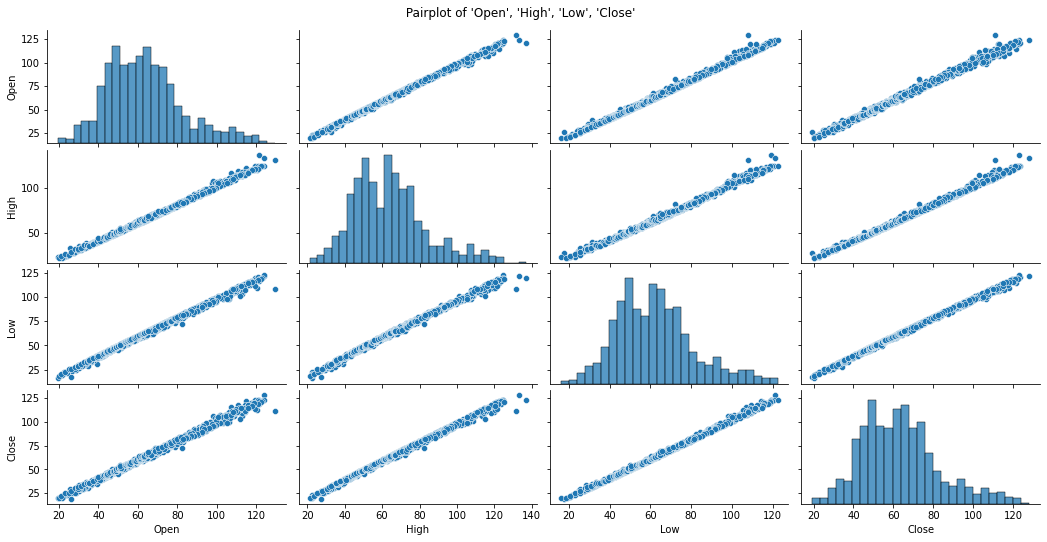

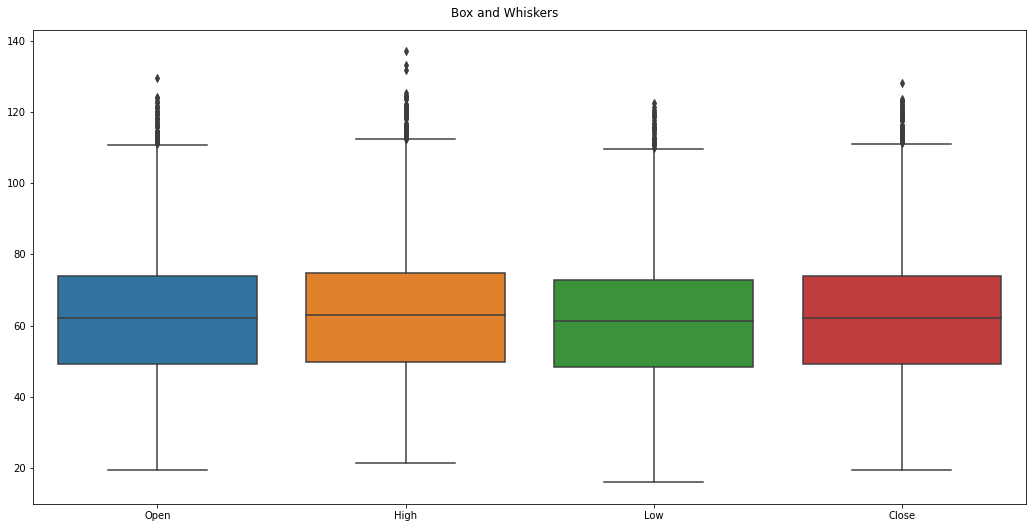

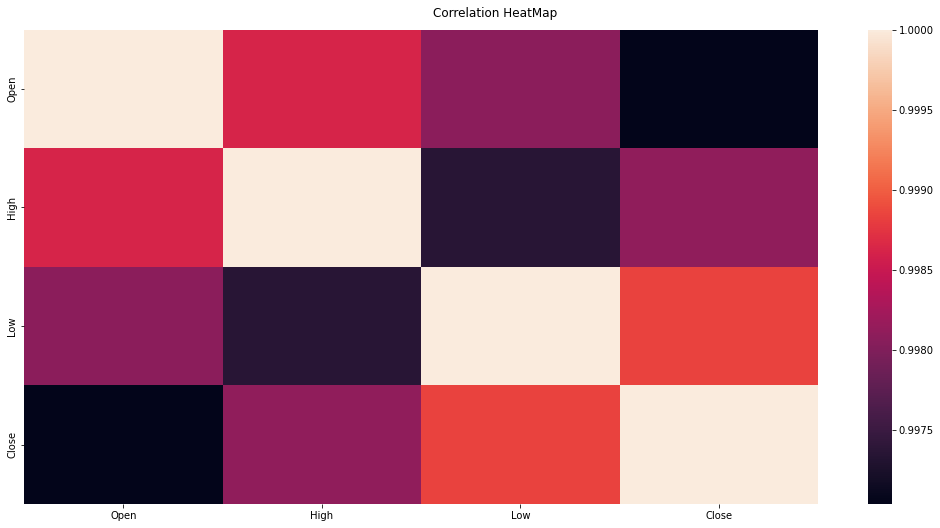

 Plot Success ***** 


In [19]:
fullDataPlots(dHs[['Open','High','Low','Close']],title=" Pairplot of %s"%str(['Open','High','Low','Close'])[1:-1]) # pairplot 
fullDataPlots(dHs[['Open','High','Low','Close']],method=sns.boxplot,title='Box and Whiskers') # boxplot 
fullDataPlots(dHs[['Open','High','Low','Close']].corr(),method=sns.heatmap,title='Correlation HeatMap') # boxplot 
multiPlots(dHs[['Open','High','Low','Close']])  # individual plots paired to each other (scatter pairs)

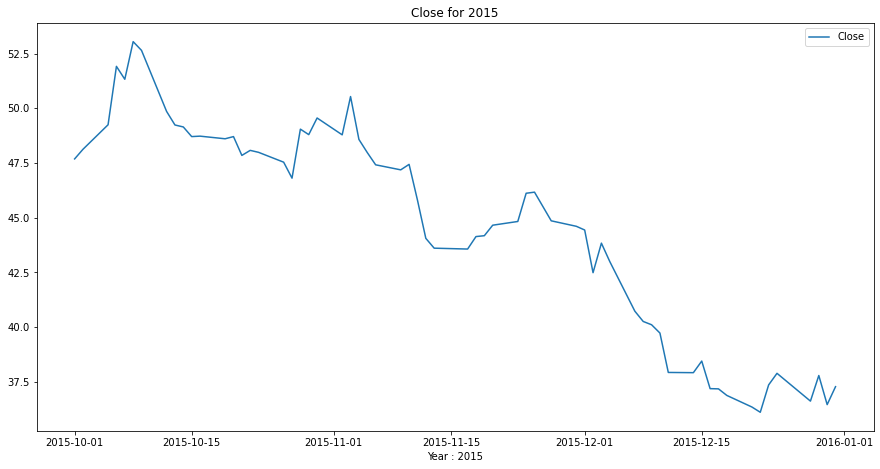

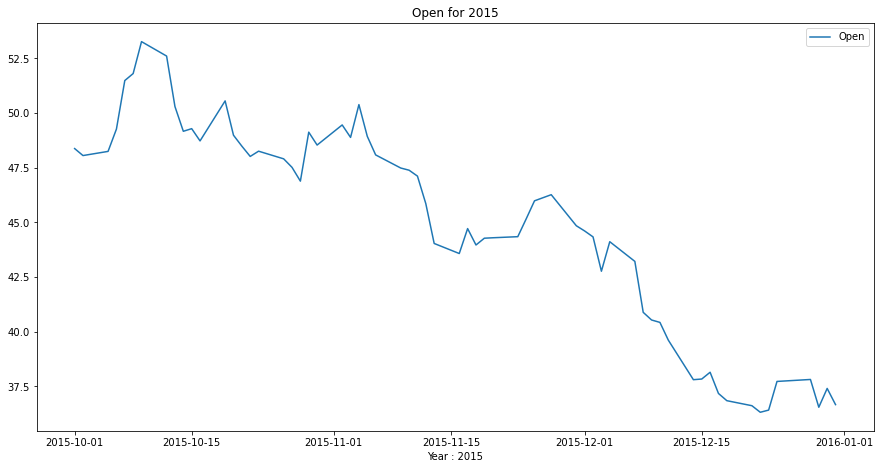

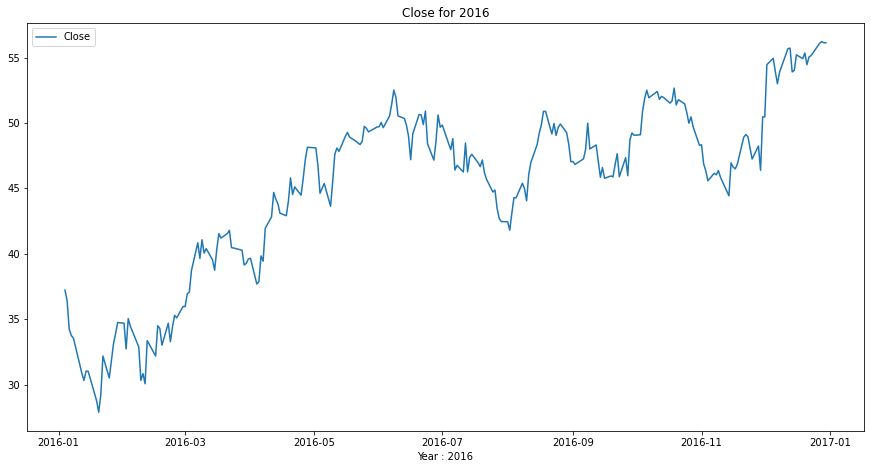

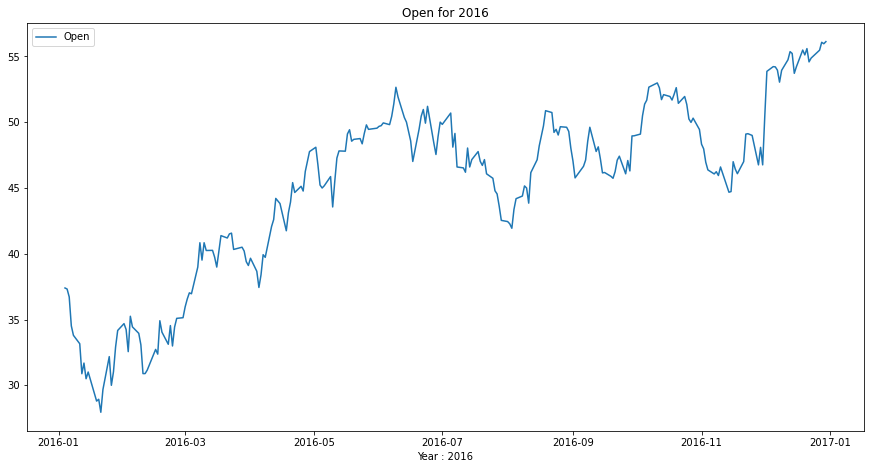

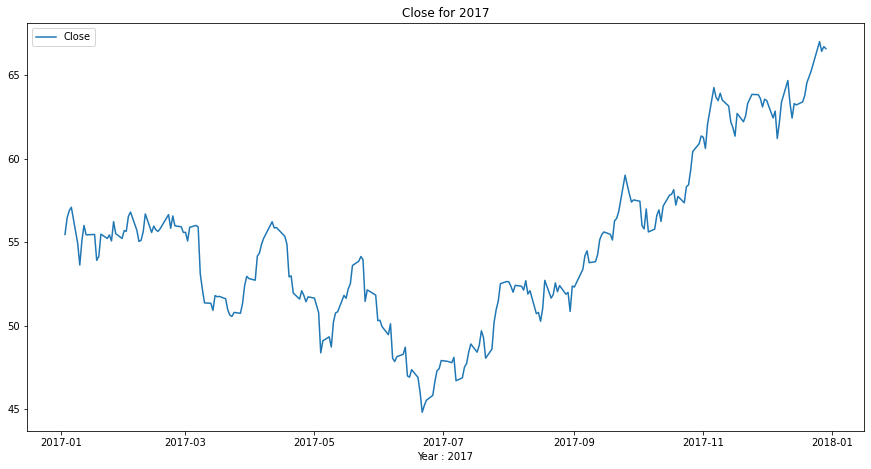

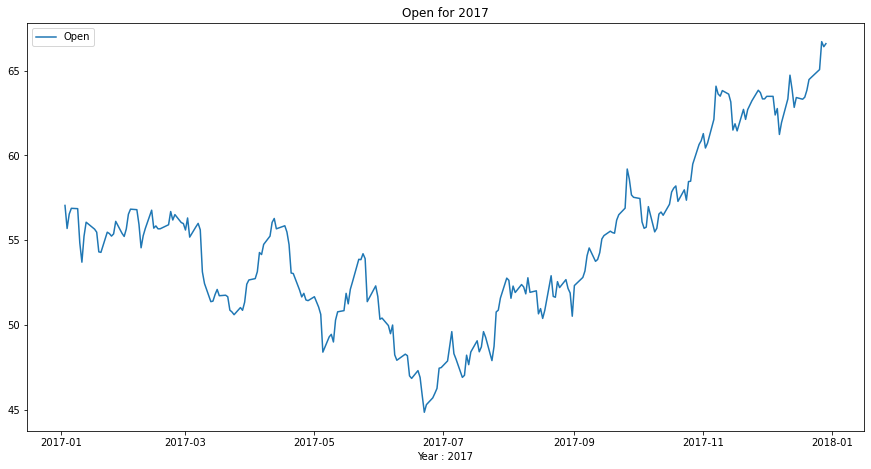

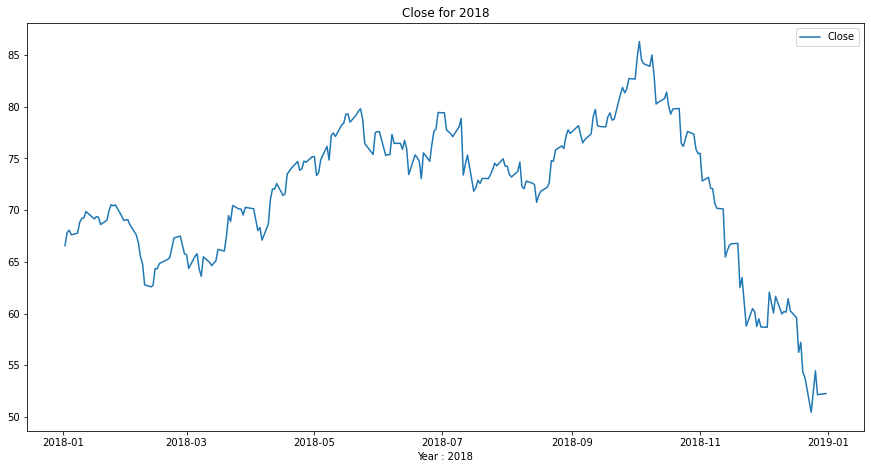

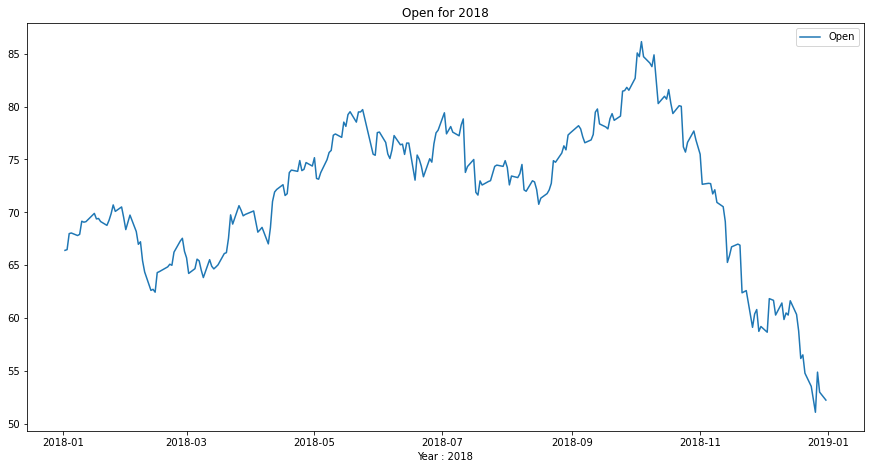

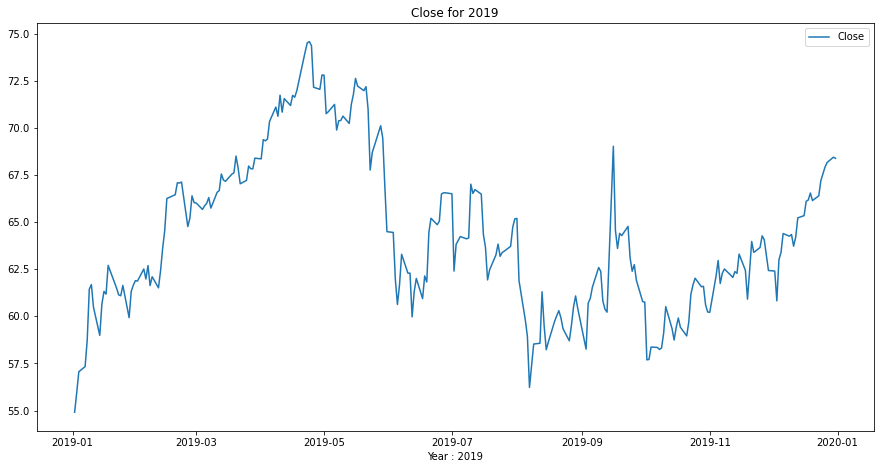

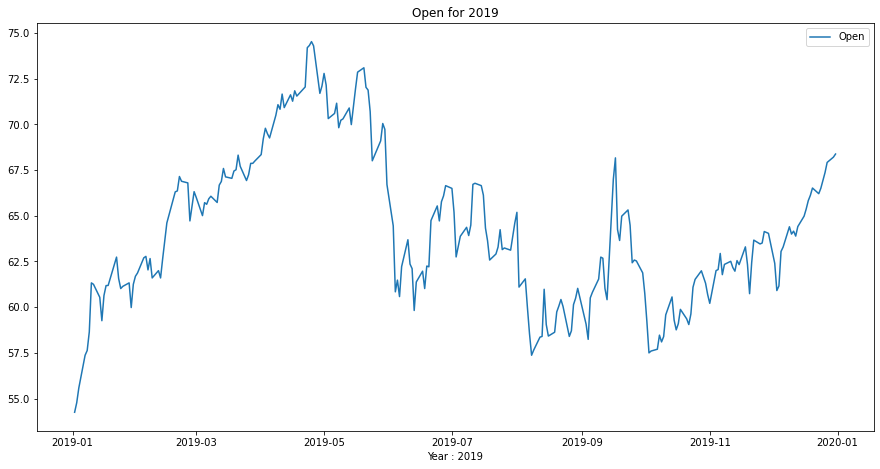

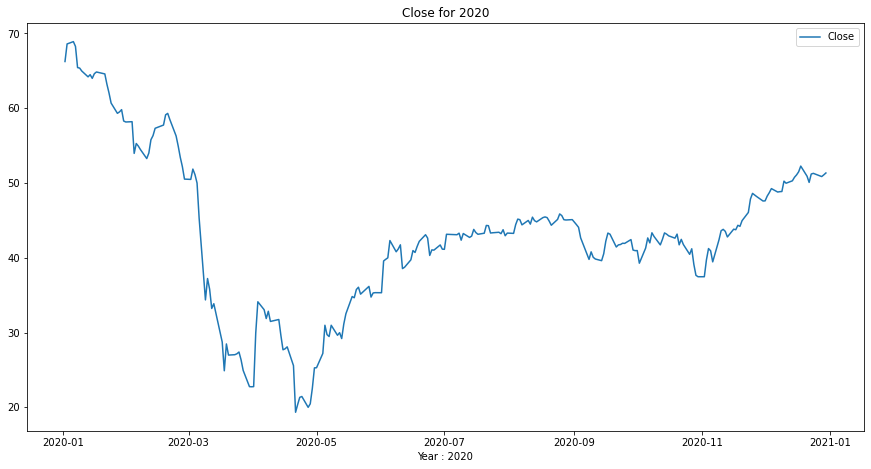

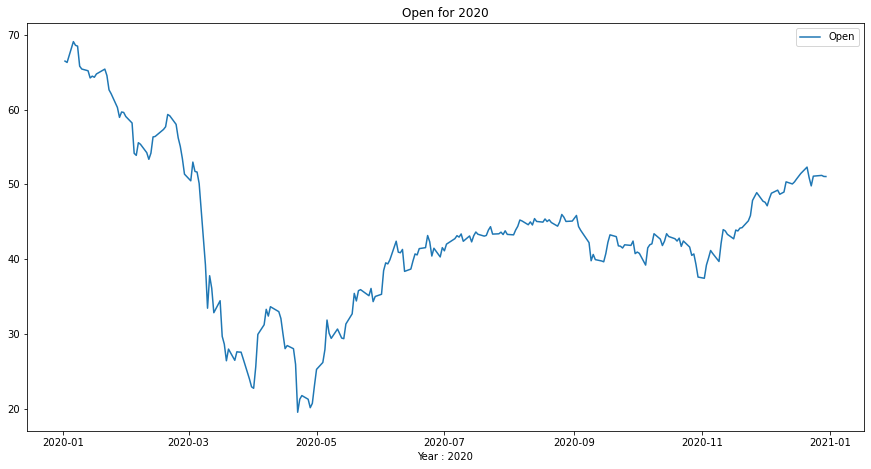

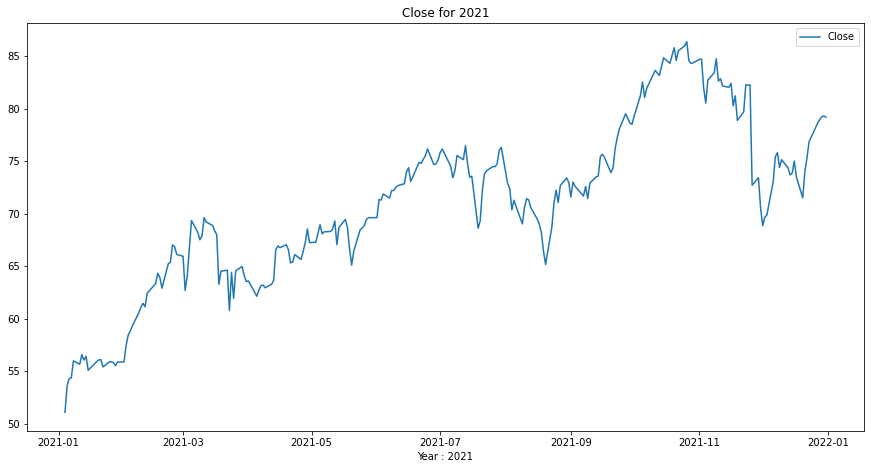

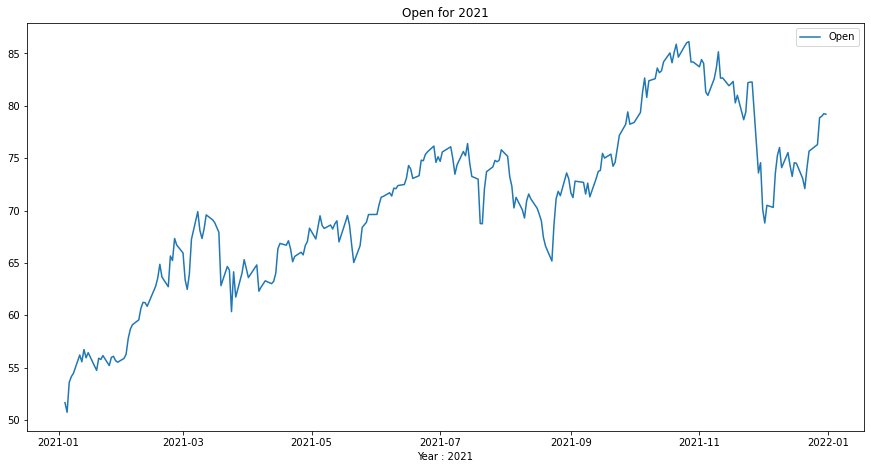

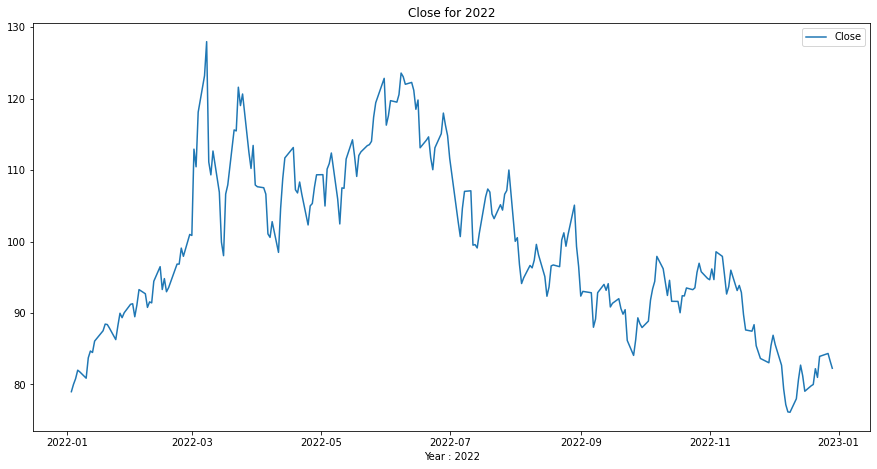

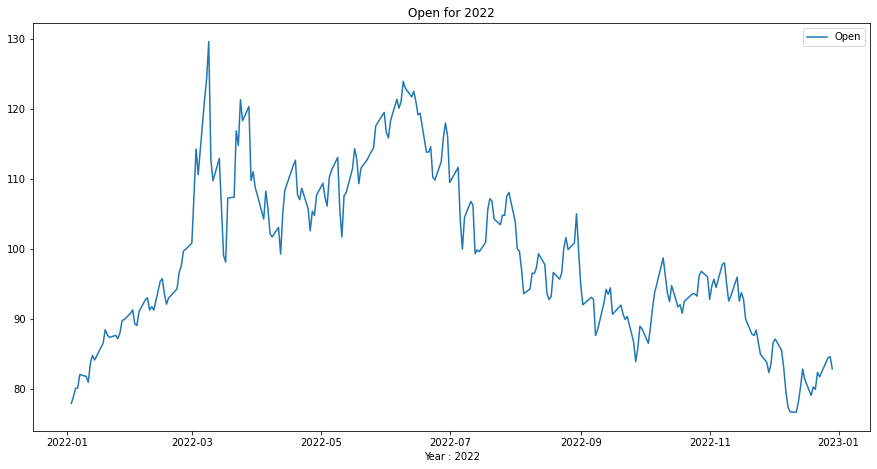

In [20]:
# per year open and close line curves 
for year in sorted(set(dHs.index.year)):
    yearVariation(dHs[['Close']],year)
    yearVariation(dHs[['Open']],year)

In [23]:
#Model Creation and study
models_name={'LR':"Linear Regression",
             'RF':"Random Forest",
             'SV':"Support Vector",
             'BR':"Bayesian Ridge"};
models_mods_norm={'LR':Forecaster(model=LinReg()),
                  'RF':Forecaster(model=RnForReg()),
                  'SV':Forecaster(model=SVR()),
                  'BR':Forecaster(model=BayesR())};
models_mods_CVKF=deepcopy(models_mods_norm);

### Train and Test (Stock process)
for mod_key in models_mods_norm:
    models_mods_norm[mod_key].pushData(data=dHs,predicts=['Open','High','Low'],infers="Close")
    models_mods_norm[mod_key].normal_split()
    models_mods_norm[mod_key].train()
    models_mods_norm[mod_key].plotMetrics(data=dHs,title="Model: "+models_name[mod_key])
    models_mods_norm[mod_key].regression_report()

[*********************100%***********************]  1 of 1 completed


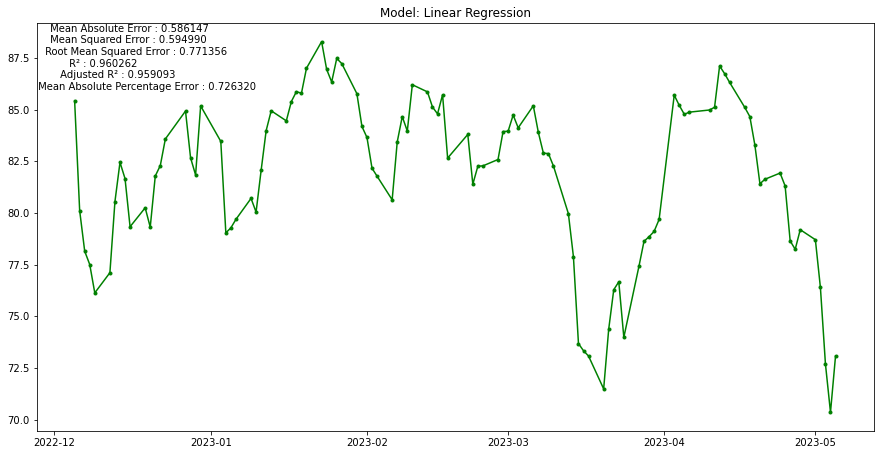

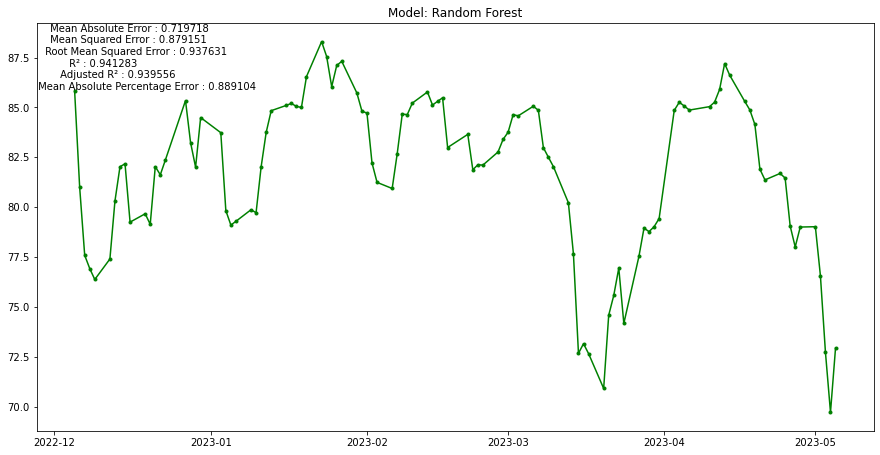

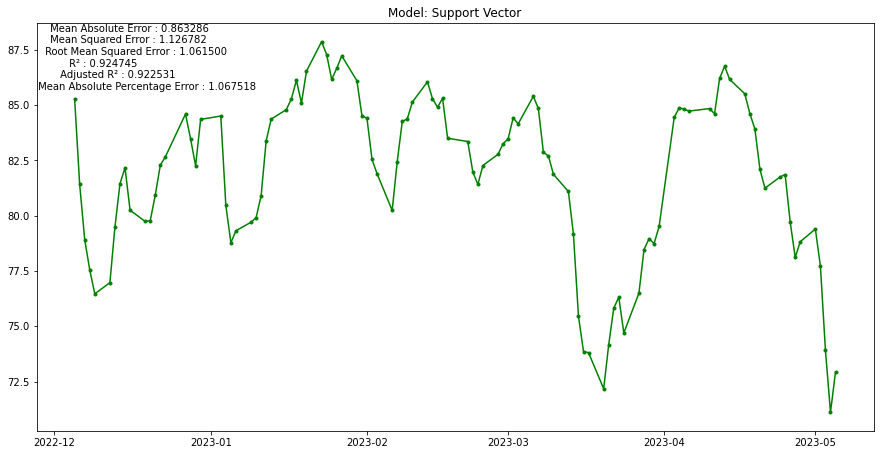

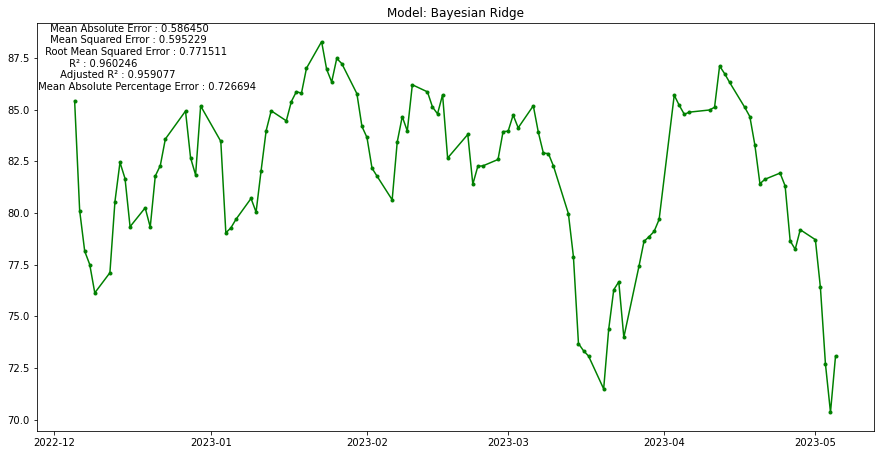

In [24]:
dHs=data_FixedTimeLine("BZ=F",start="2017-10-01",end="2022-12-30")  #for prediction
dhs2=data_Live(period='5mo')    
# Train and Test 
for mod_key in models_mods_norm:
    models_mods_norm[mod_key].pushData(data=dHs,predicts=['Open','High','Low'],infers="Close")
    models_mods_norm[mod_key].normal_split()
    models_mods_norm[mod_key].train()
    models_mods_norm[mod_key].plotMetrics(data=dhs2,title="Model: "+models_name[mod_key])

